In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os

import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_dir = '../data'
os.listdir(os.path.join(data_dir, 'hotdog'))

['train', 'test']

In [3]:
train_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/test'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bd8705d30>,
      dtype=object)

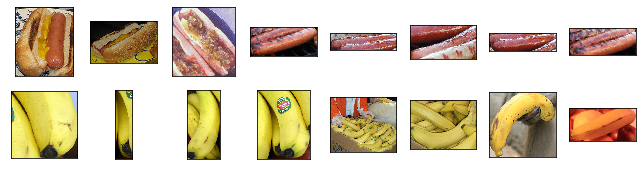

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [test_imgs[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
test_augs = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    normalize
])

In [6]:
pretrained_net = models.resnet18(pretrained=True)

In [7]:
print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [8]:
pretrained_net.fc = nn.Linear(512, 2)
print(pretrained_net.fc)

Linear(in_features=512, out_features=2, bias=True)


In [9]:
output_params = list(map(id, pretrained_net.fc.parameters()))
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())
output_params

[139895006314288, 139895006312848]

In [10]:
lr = 0.01
optimizer = optim.SGD([{'params': feature_params},
                       {'params': pretrained_net.fc.parameters(), 'lr': lr * 10}],
                       lr = lr, weight_decay=0.001)

In [11]:
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=5):
#     train_iter = DataLoader(train_imgs, transforms=train_augs, batch_size=batch_size, shuffle=True)
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'), transform=train_augs), batch_size=batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs), batch_size=batch_size)
    loss = torch.nn.CrossEntropyLoss()
    d2l.train(train_iter, test_iter,  net, loss, optimizer, device, num_epochs)

In [12]:
train_fine_tuning(pretrained_net, optimizer)

training on  cuda
epoch 1, loss 3.7991, train acc 0.679, test acc 0.932, time 12.3 sec
epoch 2, loss 0.2021, train acc 0.899, test acc 0.932, time 12.1 sec
epoch 3, loss 0.0980, train acc 0.915, test acc 0.930, time 12.1 sec
epoch 4, loss 0.0687, train acc 0.913, test acc 0.870, time 12.2 sec
epoch 5, loss 0.0341, train acc 0.950, test acc 0.949, time 12.2 sec


In [13]:
scratch_net = models.resnet18(pretrained=False,num_classes=2)
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer)

training on  cuda
epoch 1, loss 2.5147, train acc 0.607, test acc 0.767, time 12.2 sec
epoch 2, loss 0.2002, train acc 0.829, test acc 0.801, time 12.2 sec
epoch 3, loss 0.1249, train acc 0.838, test acc 0.824, time 12.2 sec
epoch 4, loss 0.0944, train acc 0.837, test acc 0.850, time 12.2 sec
epoch 5, loss 0.0734, train acc 0.845, test acc 0.856, time 12.2 sec
